# HetRec 2011
---
The 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011, http://ir.ii.uam.es/hetrec2011) has released datasets from Delicious, Last.fm Web 2.0, MovieLens, IMDb, and Rotten Tomatoes. These datasets contain social networking, tagging, and resource consuming (Web page bookmarking and music artist listening) information from sets of around 2,000 users.

The datasets were generated by the Information Retrieval Group at Universidad Autónoma de Madrid (http://ir.ii.uam.es). Before using these datasets, please review the README files for the usage license and other details.

---
**MUSIC RECOMMENDER SYSTEM**

In [1]:
import numpy as np
import pandas as pd

import csv
import os

from tqdm.notebook import tqdm

from scipy.spatial.distance import cdist

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn

import fasttext
import fasttext.util

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Data loading & correction
---

In [2]:
def dat_to_csv(dat_file, has_header=True, delimiter=',', save=False):
    with open(dat_file, 'r', encoding='cp437') as f:
        lines = f.read().split('\n')[:-1]
    
    if has_header:
        columns = lines[0].split(delimiter)
        lines = lines[1:]
    else:
        columns = [f'Column {i}' for i in range(len(lines[0].split(delimiter)))]
    
    df = pd.DataFrame(np.array([l.split(delimiter) for l in lines]), columns=columns)
    if save:
        df.to_csv(dat_file.replace('.dat', '.csv'))
    
    return df

## Last.FM dataset

In [3]:
df_lf_artists = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/artists.dat', delimiter='\t')
df_lf_tags = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/tags.dat', delimiter='\t')
df_lf_userweighted = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_artists.dat', delimiter='\t')
df_lf_usertagged = dat_to_csv('hetrec2011/hetrec2011-lastfm-2k/user_taggedartists-timestamps.dat', delimiter='\t')

In [4]:
df_lf_artists = df_lf_artists[['id', 'name']]
df_lf_artists.head()

,id,name
0,1,MALICE MIZER
1,2,Diary of Dreams
2,3,Carpathian Forest
3,4,Moi dix Mois
4,5,Bella Morte


In [5]:
df_lf_tags = df_lf_tags.rename(columns={'tagID': 'id', 'tagValue': 'value'})
df_lf_tags.head()

,id,value
0,1,metal
1,2,alternative metal
2,3,goth rock
3,4,black metal
4,5,death metal


In [6]:
df_lf_userweighted.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [7]:
df_lf_usertagged = df_lf_usertagged[['userID', 'artistID', 'tagID']]
df_lf_usertagged.head()

,userID,artistID,tagID
0,2,52,13
1,2,52,15
2,2,52,18
3,2,52,21
4,2,52,41


In [8]:
print(f'Artists: {len(df_lf_artists)}')
print(f'Tags: {len(df_lf_tags)}')
print(f'Artist user weightings: {len(df_lf_userweighted)}')
print(f'Artist user taggings: {len(df_lf_usertagged)}')

Artists: 17632
Tags: 11946
Artist user weightings: 92834
Artist user taggings: 186479


## Artists and users ids correction

First change indices data type from 'str' appropriately to 'np.int32' or 'np.float32'.

In [9]:
df_lf_usertagged['userID'] = df_lf_usertagged['userID'].astype(np.int32)
df_lf_usertagged['artistID'] = df_lf_usertagged['artistID'].astype(np.int32)
df_lf_usertagged['tagID'] = df_lf_usertagged['tagID'].astype(np.int32)

df_lf_userweighted['userID'] = df_lf_userweighted['userID'].astype(np.int32)
df_lf_userweighted['artistID'] = df_lf_userweighted['artistID'].astype(np.int32)
df_lf_userweighted['weight'] = df_lf_userweighted['weight'].astype(np.int32)

df_lf_artists['id'] = df_lf_artists['id'].astype(np.int32)

df_lf_tags['id'] = df_lf_tags['id'].astype(np.int32)

In [10]:
users = df_lf_userweighted['userID'].values
items = df_lf_userweighted['artistID'].values
ui_weightings = df_lf_userweighted['weight'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Weightings: {len(ui_weightings)}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 1892
Items: 17632
Weightings: 92834
Max user_id: 2100
Max item_id: 18745


Maximum user index 2100 and item index 18745 are out of range: 1892 and 17632. Need to reset indices for weighting prediction task.

In [11]:
user_mapping = dict(zip(np.unique(users), np.arange(n_users)))
item_mapping = dict(zip(np.unique(items), np.arange(n_items)))

In [12]:
user_rev_mapping = dict({v: k for k, v in user_mapping.items()})
item_rev_mapping = dict({v: k for k, v in item_mapping.items()})

In [13]:
df_lf_userweighted['fixed_userID'] = df_lf_userweighted['userID'].replace(user_mapping)
df_lf_userweighted['fixed_artistID'] = df_lf_userweighted['artistID'].replace(item_mapping)

In [14]:
users = df_lf_userweighted['fixed_userID'].values
items = df_lf_userweighted['fixed_artistID'].values
ui_weightings = df_lf_userweighted['weight'].values

n_users = len(np.unique(users))
n_items = len(np.unique(items))

print(f'Users: {n_users}')
print(f'Items: {n_items}')
print(f'Max user_id: {np.max(users)}')
print(f'Max item_id: {np.max(items)}')

Users: 1892
Items: 17632
Max user_id: 1891
Max item_id: 17631


Now it's ok.

# Artists recommendation
---
Aspects according to given user id:
- predicted artist weightings for user (matrix factorization / deep learning)
- artist names similarity (content based approach)
- artist user tagging similarity (collaborative filtering approach)
---
Let's perform artists recommendation for users 190 (new **180**) and 622 (new **578**).

In [15]:
USER01 = 190
USER02 = 622

print(f'User {USER01} --> weighting user: {user_mapping[USER01]}')
print(f'User {USER02} --> weighting user: {user_mapping[USER02]}')

User 190 --> weighting user: 180
User 622 --> weighting user: 578


## Weighting - Dense Feedforward NN

In [16]:
def user_weightings(user_id):
    df_common = df_lf_userweighted.merge(df_lf_artists, left_on='artistID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['artistID', 'name', 'weight']]\
    .sort_values('weight', ascending=False)

In [17]:
df_user01_weightings = user_weightings(USER01)
df_user01_weightings.head(10)

,artistID,name,weight
42680,1081,Ace of Base,21711
67524,3947,DJ BoBo,9186
67526,3948,Alcazar,3900
67532,3949,Double You,3295
12686,289,Britney Spears,3199
23278,455,Backstreet Boys,2341
67534,3950,DJ Calboy,2166
67535,3951,Mr. President,1647
67537,3952,Joy Salinas,1622
67538,3953,Alexia,1492


In [18]:
df_user02_weightings = user_weightings(USER02)
df_user02_weightings.head(10)

,artistID,name,weight
3943,154,Radiohead,3504
36590,851,Manic Street Preachers,2037
22853,440,Animal Collective,1582
80222,3505,John Zorn,1426
9408,227,The Beatles,1152
3770,152,Porcupine Tree,1143
80228,8655,Sick Animation,975
7711,206,Beck,893
10597,233,Nine Inch Nails,881
24811,475,Eminem,831


### Helpers

In [19]:
def batch(l, size):
    for i in range(0, len(l), size):
        yield l[i:i+size]

### Model

In [20]:
class DenseNet(torch.nn.Module):

    def __init__(self, n_users, n_items, n_factors, H1, D_out):
        """
        Simple Feedforward with Embeddings
        """
        super().__init__()
        # user and item embedding layers
        self.user_factors = torch.nn.Embedding(n_users, n_factors, sparse=True)
        self.item_factors = torch.nn.Embedding(n_items, n_factors, sparse=True)
        # dropout after embeddings
        self.dropout1 = torch.nn.Dropout(0.1)
        # linear layers
        self.linear1 = torch.nn.Linear(n_factors*2, H1)
        self.linear2 = torch.nn.Linear(H1, H1)
        self.linear3 = torch.nn.Linear(H1, H1)
        self.linear4 = torch.nn.Linear(H1, D_out)
        # dropout after linear layers
        self.dropout2 = torch.nn.Dropout(0.1)

    def forward(self, users, items):
        users_embedding = self.user_factors(users)
        items_embedding = self.item_factors(items)
        # concatenate user and item embeddings to form input
        x = torch.cat([users_embedding, items_embedding], 1)
        x = self.dropout1(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.dropout2(self.linear4(x))
        output_scores = F.relu(x)
        
        return output_scores

    def predict(self, users, items):
        # return the score
        output_scores = self.forward(users, items)
        return output_scores

In [21]:
class WeightingPredictor():
    
    def __init__(self, user_ids, item_ids, ui_weightings, n_factors, h1):
        """
        Artist weightings predictor for all users.
        """
        self.user_ids = user_ids
        self.item_ids = item_ids
        
        self.ui_weightings = ui_weightings
        self.n_users = np.size(np.unique(user_ids))
        self.n_items = np.size(np.unique(item_ids))
        
        self.n_factors = n_factors
        self.h1 = h1
        
        self.__model = DenseNet(self.n_users, self.n_items, n_factors=self.n_factors, H1=self.h1, D_out=1)
        self.__loss = torch.nn.MSELoss()
        self.__optim = torch.optim.SGD(self.__model.parameters(), lr=1e-6)
        
    
    def fit(self, epochs, batch_size, save_progress=False):
        if save_progress:
            with open(f'hetrec2011/aw_prog_{self.n_factors}f_{self.h1}h.csv', 'w') as f:
                csv.writer(f).writerow(['epoch loss'])
        
        t = tqdm(range(epochs))
        for epoch in t:
            t.set_postfix_str(f'Epoch {epoch + 1}/{epochs}')
            us_b = batch(self.user_ids, size=batch_size)
            is_b = batch(self.item_ids, size=batch_size)
            uiws_b = batch(self.ui_weightings, size=batch_size)
            epoch_loss = 0
            
            tt = tqdm(zip(us_b, is_b, uiws_b),
                      total=int(np.size(self.ui_weightings)/batch_size + 1), leave=False)
            for u, i, uiw in tt:
                # get user, item and weight data batch
                user = Variable(torch.LongTensor(u))
                item = Variable(torch.LongTensor(i))
                weight = Variable(torch.FloatTensor(uiw))

                # predict
                prediction = self.__model(user, item)
                #target = (prediction.reshape(-1) <= weight).int() - (prediction.reshape(-1) > weight).int()
                loss = self.__loss(prediction.reshape(-1), weight)
                epoch_loss += loss.detach().numpy()
                tt.set_postfix_str(f'Current MSE loss: {np.round(np.float64(loss.detach().numpy()), 4)} ' +
                                   f'| Total: {np.round(epoch_loss, 4)}')

                # backpropagate
                loss.backward()

                # update weights
                self.__optim.step()
            
            #save current artist-weighting progress step
            if save_progress:
                with open(f'hetrec2011/aw_prog_{self.n_factors}f_{self.h1}h.csv', 'a+') as f:
                    csv.writer(f).writerow([epoch_loss])
    
    def predict(self, user_id):
        user_id = user_mapping[user_id]
        users_tensor = torch.tensor([user_id]*np.size(self.item_ids))
        items_tensor = torch.tensor(self.item_ids)
        return self.__model(users_tensor, items_tensor).flatten().detach().numpy()

### Tests

In [22]:
BATCH_SIZE = 64
EPOCHS = 1

In [23]:
INPUT_FACTORS = 20
HIDDEN_FACTORS = 60

In [24]:
WP_MODEL_PATH = f'hetrec2011/wp_model_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h'

In [25]:
df_userweighted_names = df_lf_userweighted.merge(df_lf_artists, left_on='artistID', right_on='id')
df_userweighted_names

,userID,artistID,weight,fixed_userID,fixed_artistID,id,name
0,2,51,13883,0,45,51,Duran Duran
1,4,51,228,2,45,51,Duran Duran
2,27,51,85,24,45,51,Duran Duran
3,28,51,10,25,45,51,Duran Duran
4,62,51,528,59,45,51,Duran Duran
...,...,...,...,...,...,...,...
92829,2100,18726,337,1891,17615,18726,Nyktalgia
92830,2100,18727,297,1891,17616,18727,Atsakau niekadA
92831,2100,18728,281,1891,17617,18728,Domantas Razauskas
92832,2100,18729,280,1891,17618,18729,Atalyja


In [26]:
if not os.path.exists(WP_MODEL_PATH):
    wp = WeightingPredictor(
        df_userweighted_names['fixed_userID'].values,
        df_userweighted_names['fixed_artistID'].values,
        df_userweighted_names['weight'].values,
        n_factors=INPUT_FACTORS, h1=HIDDEN_FACTORS)
    wp.fit(epochs=EPOCHS, batch_size=BATCH_SIZE, save_progress=True)
    torch.save(wp, WP_MODEL_PATH)
else:
    wp = torch.load(WP_MODEL_PATH)

/home/jakub/Dokumenty/venv36/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DenseNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [27]:
def prediction_quality_plot(input_file, title, save_file=None):
    df = pd.read_csv(input_file)
    
    plt.plot(df.index + 1, df['epoch loss'], label='epoch MSE loss')
    plt.scatter(df.index + 1, df['epoch loss'])
    plt.xticks(df.index + 1)
    
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    for k, v in zip(df.index + 1, df['epoch loss']):
        plt.annotate(np.round(v, 4), (k, v), size=16, horizontalalignment='center', verticalalignment='bottom')
    
    plt.legend(loc='best')
    
    if save_file:
        plt.savefig(save_file)
    plt.show()

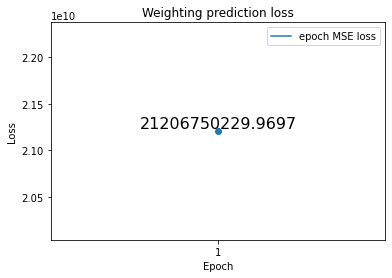

In [28]:
prediction_quality_plot(input_file=f'hetrec2011/aw_prog_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.csv',
                        title='Weighting prediction loss',
                        save_file=f'hetrec2011/weighting_prediction_loss_{INPUT_FACTORS}f_{HIDDEN_FACTORS}h.png')

In [29]:
def weightings_recommendations(df, predictions):
    df_all = pd.DataFrame({
        'artistID': df['artistID'].values,
        'name': df['name'].values,
        'pred. weight': predictions
    }).drop_duplicates()
    
    df_all = df_all.groupby(['artistID', 'name'])['pred. weight'].apply(np.max).to_frame().reset_index()
    
    return df_all.sort_values('pred. weight', ascending=False)

In [30]:
df_user01_weightings_recommendations = weightings_recommendations(df_userweighted_names, wp.predict(USER01))
df_user01_weightings_recommendations

,artistID,name,pred. weight
0,1,MALICE MIZER,97.234871
11433,11832,T9,97.234871
11435,11834,Christafari,97.234871
11436,11835,Paprika Korps,97.234871
11437,11836,Elektryczne Gitary,97.234871
...,...,...,...
3409,3446,The Brides,0.000000
9753,10009,M├║m M├║sikvatur,0.000000
16096,17023,Choir of Young Believers,0.000000
5367,5489,Perfidious Words,0.000000


In [31]:
df_user02_weightings_recommendations = weightings_recommendations(df_userweighted_names, wp.predict(USER02))
df_user02_weightings_recommendations

,artistID,name,pred. weight
3012,3032,Comeback Kid,265.970276
698,704,The Pretty Reckless,210.127213
2370,2385,Flaw,194.840408
9113,9346,Temple of the Dog,191.679703
1297,1306,Above & Beyond,168.208145
...,...,...,...
10773,11114,Orphx,0.000000
10774,11115,Geomatic,0.000000
10775,11116,Totakeke,0.000000
10776,11117,Imminent Starvation,0.000000


## Titles - Content Based Approach

Each artist has name. Task is to calculate cosine similarity of vectorized names.

In [32]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [33]:
names = df_lf_artists['name'].values
names_embeddings = np.array([ft_model[n] for n in names])

In [34]:
del ft_model

In [35]:
cosine_mtx = cdist(names_embeddings, names_embeddings, 'cosine')
cosine_mtx = np.subtract(np.ones(cosine_mtx.shape), cosine_mtx)

df_cosine_sim = pd.DataFrame(cosine_mtx,
                             index=df_lf_artists['id'].values,
                             columns=df_lf_artists['id'].values)
df_cosine_sim

,1,2,3,4,5,6,7,8,9,10,...,18736,18737,18738,18739,18740,18741,18742,18743,18744,18745
1,1.000000,0.474865,0.489505,0.314527,0.393050,0.202281,0.479717,0.313752,0.148893,0.203693,...,0.218983,0.288147,0.190463,0.345959,0.426064,0.342597,0.303223,0.355858,0.289311,0.464350
2,0.474865,1.000000,0.550310,0.356823,0.566883,0.090654,0.529828,0.402167,0.036982,0.113198,...,0.262914,0.547074,-0.021143,0.378701,0.427511,0.295467,0.146932,0.578920,0.327925,0.504941
3,0.489505,0.550310,1.000000,0.387340,0.515359,0.145962,0.470031,0.320694,0.047589,0.158989,...,0.246005,0.358409,0.092532,0.356065,0.435052,0.346365,0.217965,0.485101,0.306268,0.386451
4,0.314527,0.356823,0.387340,1.000000,0.389738,0.128492,0.451046,0.381914,0.117615,0.076289,...,0.291228,0.249575,0.124406,0.428410,0.342176,0.285429,0.098466,0.425688,0.243801,0.326803
5,0.393050,0.566883,0.515359,0.389738,1.000000,0.175393,0.501535,0.282736,0.098300,0.117192,...,0.191073,0.380885,0.077400,0.421567,0.338498,0.318965,0.294620,0.459357,0.203660,0.466568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18741,0.342597,0.295467,0.346365,0.285429,0.318965,0.136002,0.288741,0.108488,0.006737,0.171721,...,0.133673,0.229097,0.052008,0.237704,0.310470,1.000000,0.196403,0.306718,0.097975,0.315277
18742,0.303223,0.146932,0.217965,0.098466,0.294620,0.076233,0.263336,0.016115,0.031550,0.087361,...,0.032214,0.085651,0.101286,0.156185,0.249468,0.196403,1.000000,0.140472,-0.068130,0.268581
18743,0.355858,0.578920,0.485101,0.425688,0.459357,0.039310,0.467522,0.347938,-0.004800,0.047043,...,0.243556,0.389410,-0.021976,0.363895,0.378800,0.306718,0.140472,1.000000,0.242417,0.462298
18744,0.289311,0.327925,0.306268,0.243801,0.203660,-0.005197,0.291637,0.350785,0.069651,0.085590,...,0.152186,0.230268,0.103869,0.267264,0.148021,0.097975,-0.068130,0.242417,1.000000,0.234318


In [36]:
N_HIGHEST = 10

Take **N_HIGHEST** user artist weightings and then for each taken artist calculate cosine similarities. Stack them vertically and calculate summaric similarity aggregating by 'artistID'.

In [37]:
def users_names_most_similar(df, n_highest=N_HIGHEST):
    df_highest = df[:n_highest][['artistID']]
    
    df_all = pd.DataFrame(columns=df_highest.columns)
    
    for i, row in df_highest.iterrows():
        sims = df_cosine_sim[int(row['artistID'])].values
        df_sims = pd.DataFrame({
            'artistID': df_cosine_sim.index,
            's': sims
        })
        
        df_all = pd.concat([df_all, df_sims])
    
    df_all = df_all.groupby('artistID')['s']\
                   .apply(np.sum)
    
    df_all = pd.DataFrame({
        'artistID': df_all.index,
        'sum sim.': df_all.values
    })
    
    return df_all.merge(df_lf_artists, left_on='artistID', right_on='id')[['artistID', 'name', 'sum sim.']]\
                 .sort_values('sum sim.', ascending=False)

In [38]:
df_user01_names_similarities = users_names_most_similar(df_user01_weightings)
df_user01_names_similarities

,artistID,name,sum sim.
10482,10781,"Demi Lovato, Meaghan Martin, Jordan Francis, A...",4.315341
8234,8435,"Vedat Y─▒ld─▒r─▒m, ├ûzg├╝r Akg├╝l, Mehmet Erdem",4.086934
13283,13841,Green Day & the Cast of American Idiot,4.044087
10480,10779,"Demi Lovato, Alyson Stoner, Anna Maria Perez d...",4.027157
5731,5856,Dolphins Into the Future,4.018042
...,...,...,...
9088,9321,The The,-0.291608
12087,12525,Sk6,-0.430801
2088,2103,-OZ-,-0.476597
8313,8514,Si*S├⌐,-0.550019


In [39]:
df_user02_names_similarities = users_names_most_similar(df_user02_weightings)
df_user02_names_similarities

,artistID,name,sum sim.
10482,10781,"Demi Lovato, Meaghan Martin, Jordan Francis, A...",4.582925
4776,4886,Demi Lovato Ft. Miley Cyrus Ft. Selena Gomez F...,4.499673
8740,8973,"Snoop Dogg, Charlie Wilson & Justin Timberlake",4.394463
842,851,Manic Street Preachers,4.316594
10480,10779,"Demi Lovato, Alyson Stoner, Anna Maria Perez d...",4.294280
...,...,...,...
8619,8829,µóàµ₧ùΦîé,-0.477919
3241,3278,HK119,-0.509832
8313,8514,Si*S├⌐,-0.518116
12087,12525,Sk6,-0.792901


## User weighting - Collaborative Filtering Approach

Some certain artists have some certain user taggings. Group user tagging by artist and then calculate the mean of cosine similarities for each vectorized tags pair. At the end take maximum artist tagging values (group by artists).

In [40]:
srs_user_taglists = df_lf_usertagged.merge(df_lf_tags, left_on='tagID', right_on='id', how='left')\
                                    .drop(['tagID', 'id'], axis=1).groupby(['userID', 'artistID'])['value']\
                                    .apply(lambda x: ', '.join(np.sort(x)))
srs_uid, srs_aid = np.array([*srs_user_taglists.index]).T
df_user_taglists = pd.DataFrame({
    'userID': srs_uid,
    'artistID': srs_aid,
    'tags': srs_user_taglists.values
})
del srs_uid, srs_aid
df_user_taglists = df_user_taglists.merge(df_lf_artists, left_on='artistID', right_on='id', how='left')\
                                   .drop('id', axis=1)
df_user_taglists[['userID', 'artistID', 'name', 'tags']]  # tags must be ordered ascendingly

,userID,artistID,name,tags
0,2,52,Morcheeba,"chillout, downtempo, electronic, female vovali..."
1,2,63,Enigma,"ambient, chillout, gregorian chant, new age"
2,2,73,Caf├⌐ Del Mar,"acid jazz, ambient, atmospheric, chillout, dow..."
3,2,94,Ministry of Sound,"acid jazz, chillout, club house, dance, downte..."
4,2,96,Fleetwood Mac,"80's, pop"
...,...,...,...,...
71059,2100,3855,Andrius Mamontovas,melancholic rock
71060,2100,6658,Lifelover,"black metal, depressive black metal, suicidal ..."
71061,2100,8322,Am┼╛ius,"black metal, lithuanian black metal, pagan bla..."
71062,2100,13978,Vilkduja,dark ambient


In [41]:
def user_taggings(user_id):
    df_common = df_user_taglists.merge(df_lf_artists.drop('name', axis=1), left_on='artistID', right_on='id')
    return df_common.loc[df_common['userID'] == user_id][['artistID', 'name', 'tags']]

In [42]:
df_user01_taggings = user_taggings(USER01)
df_user01_taggings

,artistID,name,tags
75,94,Ministry of Sound,cover
904,157,Michael Jackson,pop dance
1753,463,Savage Garden,slow
3624,288,Rihanna,"house music, pop dance"
3841,335,Sandy,"brasil, brazil"
...,...,...,...
46977,15707,DJ Dado,house
46979,16765,Bette Midler,house music
46982,17486,Erika,"00s, dance, electronic, eurodance, female, fem..."
46985,18300,Ken Laszlo,cover


In [43]:
df_user02_taggings = user_taggings(USER02)
df_user02_taggings

,artistID,name,tags
681,152,Porcupine Tree,"beautiful, epic, melancholy, progressive rock,..."
6146,440,Animal Collective,avant-garde
16653,964,The Mars Volta,"progressive punk, progressive rock"
22387,616,Squarepusher,avant-garde
34081,2473,Fant├┤mas,"avant-garde, experimental, metal, mike patton"


In [44]:
ft_model = fasttext.load_model('cc.en.300.bin')

In [45]:
tags = df_user_taglists['tags'].values
taglists_embeddings = np.array([ft_model[t] for t in tags])

tags01 = df_user01_taggings['tags'].values
user01_taglists_embeddings = np.array([ft_model[t] for t in tags01])

tags02 = df_user02_taggings['tags'].values
user02_taglists_embeddings = np.array([ft_model[t] for t in tags02])

In [46]:
del ft_model

In [47]:
def users_taggings_most_similar(df, embeddings):
    
    cosine_sims = cdist(taglists_embeddings, embeddings, 'cosine')
    cosine_sims = np.subtract(np.ones(cosine_sims.shape), cosine_sims)
    mean_sims = np.mean(cosine_sims, axis=1)
    
    df_all = pd.DataFrame(df_user_taglists)
    df_all['sum sim.'] = mean_sims
    
    sums = df_all.groupby(['artistID', 'name'])['sum sim.'].apply(np.sum).to_frame().reset_index()
    
    # reduce to single movies with highest similarity score
    single_titles = sums[['artistID', 'name', 'sum sim.']].groupby(['artistID', 'name'])['sum sim.']\
                                                           .apply(np.max).to_frame().reset_index()
    
    return single_titles.sort_values('sum sim.', ascending=False)

In [48]:
df_user01_taggings_similarities = users_taggings_most_similar(df_user01_taggings, user01_taglists_embeddings)
df_user01_taggings_similarities

,artistID,name,sum sim.
247,289,Britney Spears,76.668938
82,89,Lady Gaga,69.437921
156,190,Muse,63.083811
192,227,The Beatles,60.920254
60,67,Madonna,59.141004
...,...,...,...
1883,2122,Miles Kane,0.011373
5679,7210,Batlik,0.011373
9114,12799,Administrator,0.000000
11273,17081,Enrique Guzm├ín,-0.010116


In [49]:
df_user02_taggings_similarities = users_taggings_most_similar(df_user02_taggings, user02_taglists_embeddings)
df_user02_taggings_similarities

,artistID,name,sum sim.
247,289,Britney Spears,68.157132
156,190,Muse,65.158473
82,89,Lady Gaga,62.848304
192,227,The Beatles,59.062031
65,72,Depeche Mode,54.025006
...,...,...,...
10110,14682,Flat Earth Society,0.024243
11273,17081,Enrique Guzm├ín,0.023953
10782,16048,Santos,0.023323
9114,12799,Administrator,0.000000


## Hybrid recommendation

Perform an outer merge of artist predicted weightings and similarities dataframes and calculate recommendation ratio.

Columns:
- **artistID** - artist id
- **name** - artist name
- **pred. weighting** - predicted artist weightings
- **names sim.** - total names cosine similarity of **N_HIGHEST** weighted movies
- **tags sim.** - total tagging cosine similarity of all user taggings (max values)
- **sc. ...** - scaled to 0-1 given value
- **rec. ratio** - general recommender system ratio {**40%** weighting, **40%** names, **20%** tags}

In [50]:
def hybrid_recommendation(df_weightings, df_names_sims, df_tags_sims, save_file=None):
    df_hybrid = df_weightings.merge(df_names_sims, left_on='artistID', right_on='artistID', how='outer')
    df_hybrid['name_x'] = df_hybrid['name_x'].fillna(df_hybrid['name_y'])
    df_hybrid = df_hybrid.rename(columns={'name_x': 'name', 'sum sim.': 'names sim.'})\
                         .drop('name_y', axis=1)
    
    df_hybrid = df_hybrid.merge(df_tags_sims, left_on='artistID', right_on='artistID', how='outer')
    df_hybrid['name_x'] = df_hybrid['name_x'].fillna(df_hybrid['name_y'])
    df_hybrid = df_hybrid.rename(columns={'name_x': 'name', 'sum sim.': 'tags sim.'})\
                         .drop('name_y', axis=1)
    
    # replace NaN values
    df_hybrid = df_hybrid.fillna(0.)
    
    # scale all 4 measures to 0-1 interval
    mn, mx = df_hybrid['pred. weight'].min(), df_hybrid['pred. weight'].max()
    df_hybrid['sc. weight'] = (df_hybrid['pred. weight'] - mn)/(mx - mn)
    mn, mx = df_hybrid['names sim.'].min(), df_hybrid['names sim.'].max()
    df_hybrid['sc. names'] = (df_hybrid['names sim.'] - mn)/(mx - mn)
    mn, mx = df_hybrid['tags sim.'].min(), df_hybrid['tags sim.'].max()
    df_hybrid['sc. tags'] = (df_hybrid['tags sim.'] - mn)/(mx - mn)
    
    # finally (40%:40%:20%)
    df_hybrid['ratio'] = df_hybrid.apply(lambda x: 0.4*x['sc. weight'] + 0.4*x['sc. names'] +
                                         0.2*x['sc. tags'], axis=1)
    df_hybrid = df_hybrid.sort_values('ratio', ascending=False)
    
    if save_file:
        df_hybrid.to_csv(save_file, index=False)
    
    return df_hybrid

In [51]:
df_user01_hr = hybrid_recommendation(df_user01_weightings_recommendations, df_user01_names_similarities,
                                     df_user01_taggings_similarities,
                                     save_file='hetrec2011/user01_artist_rec.csv')
df_user01_hr

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio
11531,289,Britney Spears,97.234871,3.885975,76.668938,1.0,0.918773,1.000000,0.967509
11334,89,Lady Gaga,97.234871,2.883673,69.437921,1.0,0.729157,0.905856,0.872834
11534,292,Christina Aguilera,97.234871,3.219212,58.791923,1.0,0.792634,0.767250,0.870504
11285,72,Depeche Mode,97.234871,3.034755,56.651427,1.0,0.757739,0.739382,0.850972
12558,1412,Led Zeppelin,97.234871,3.258028,39.684204,1.0,0.799978,0.518476,0.823686
...,...,...,...,...,...,...,...,...,...
17133,2120,IU,0.000000,0.121615,0.000000,0.0,0.206631,0.001807,0.083014
16443,8597,OIH,0.000000,0.104635,0.436832,0.0,0.203419,0.007494,0.082866
16738,8496,AoW,0.000000,0.037672,0.000000,0.0,0.190751,0.001807,0.076662
16995,11041,XBXRX,0.000000,-0.069193,0.395760,0.0,0.170534,0.006960,0.069606


In [52]:
df_user02_hr = hybrid_recommendation(df_user02_weightings_recommendations, df_user02_names_similarities,
                                     df_user02_taggings_similarities,
                                     save_file='hetrec2011/user02_artist_rec.csv')
df_user02_hr

,artistID,name,pred. weight,names sim.,tags sim.,sc. weight,sc. names,sc. tags,ratio
6657,289,Britney Spears,97.234871,4.045613,68.157132,0.365585,0.901991,1.000000,0.707031
0,3032,Comeback Kid,265.970276,2.961088,3.151555,1.000000,0.704168,0.048229,0.691313
6517,89,Lady Gaga,97.234871,3.410109,62.848304,0.365585,0.786072,0.922271,0.645117
5,291,Kelly Clarkson,163.389908,3.450240,26.764050,0.614316,0.793392,0.393948,0.641873
10,329,Justin Timberlake,145.250336,4.038596,19.458273,0.546115,0.900711,0.286982,0.636127
...,...,...,...,...,...,...,...,...,...
13171,9006,Yogo!Yogo!,0.000000,-0.341013,0.000000,0.000000,0.101846,0.002086,0.041156
16083,2103,-OZ-,0.000000,-0.381272,0.000000,0.000000,0.094502,0.002086,0.038218
13648,3278,HK119,0.000000,-0.509832,0.000000,0.000000,0.071052,0.002086,0.028838
14475,8514,Si*S├⌐,0.000000,-0.518116,0.000000,0.000000,0.069541,0.002086,0.028234
